In [1]:
# Configuration
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
# --- Standard Libraries ---
import sys
import os
import json
import time
import copy
import cmath
import pickle
import logging
import argparse

# Path configuration (only run once)
sys.path.append(gems_tco_path)

# --- Third-Party Libraries ---
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Any, Callable
from json import JSONEncoder

# Data manipulation and analysis
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import typer

# Torch and Numerical Libraries
import torch
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.pyplot as plt 

# --- Custom (GEMS_TCO) Imports ---
import GEMS_TCO
from GEMS_TCO import kernels_reparam_space_time_gpu
from GEMS_TCO import data_preprocess, data_preprocess as dmbh
from GEMS_TCO import orderings as _orderings 

from GEMS_TCO import alg_optimization
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2
from GEMS_TCO import debiased_whittle

load monthly data

In [6]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 

lat_range_input=[0,5]      
lon_range_input=[123, 133] 

df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

In [7]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= ord_mm,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_vecc.append( day_aggregated_tensor )
    daily_hourly_maps_vecc.append( day_hourly_map )
print(daily_aggregated_tensors_vecc[0].shape)
#print(daily_hourly_maps[0])
nn = daily_aggregated_tensors_vecc[0].shape[0]

torch.Size([46736, 4])


difference data

In [11]:
a = [13.357, 0.1441, 0.1855, 1.1652, 0.0197,-0.1576,0]
day = 0 # 0 index
lat_range= [0,5]
lon_range= [123.0, 133.0]
db = debiased_whittle.debiased_whittle_preprocess(daily_aggregated_tensors_dw, daily_hourly_maps_dw, day_idx=day, params_list=a, lat_range=lat_range, lon_range=lon_range)

subsetted_aggregated_day = db.generate_spatially_filtered_days(0,5,123,133)
print(subsetted_aggregated_day.shape)
N2= subsetted_aggregated_day.shape[0]
print(N2)
subsetted_aggregated_day

torch.Size([45360, 4])
45360


tensor([[ 2.0000e-02,  1.2306e+02,  7.0969e-01,  2.1000e+01],
        [ 2.0000e-02,  1.2313e+02,  1.6618e+00,  2.1000e+01],
        [ 2.0000e-02,  1.2319e+02,  2.6658e+00,  2.1000e+01],
        ...,
        [ 1.9560e+00,  1.3081e+02,  3.7727e+00,  2.8000e+01],
        [ 1.9560e+00,  1.3087e+02,  3.4274e+00,  2.8000e+01],
        [ 1.9560e+00,  1.3094e+02, -5.9504e-01,  2.8000e+01]],
       dtype=torch.float64)

multivariate

Running on: cpu
--- Day 1 Diagnostic Plot (New Multivariate Tapered Logic) ---
Params (Log-Space) on device: tensor([ 4.2851,  1.7148,  0.5026, -4.6815,  0.0218, -0.1600,    -inf],
       dtype=torch.float64)
Generating J-Vector and Taper Grid...


/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_69231/4009012827.py:244: RuntimeWarning: divide by zero encountered in log
  np.log(nugget_val)


Grid: 45x126, Time Points: 8
Calculating Sample Periodogram...
Calculating Taper Autocorrelation...
Calculating Expected Periodogram (Using Aliasing Sum)...

Stats: Mean=0.64, Median=0.58


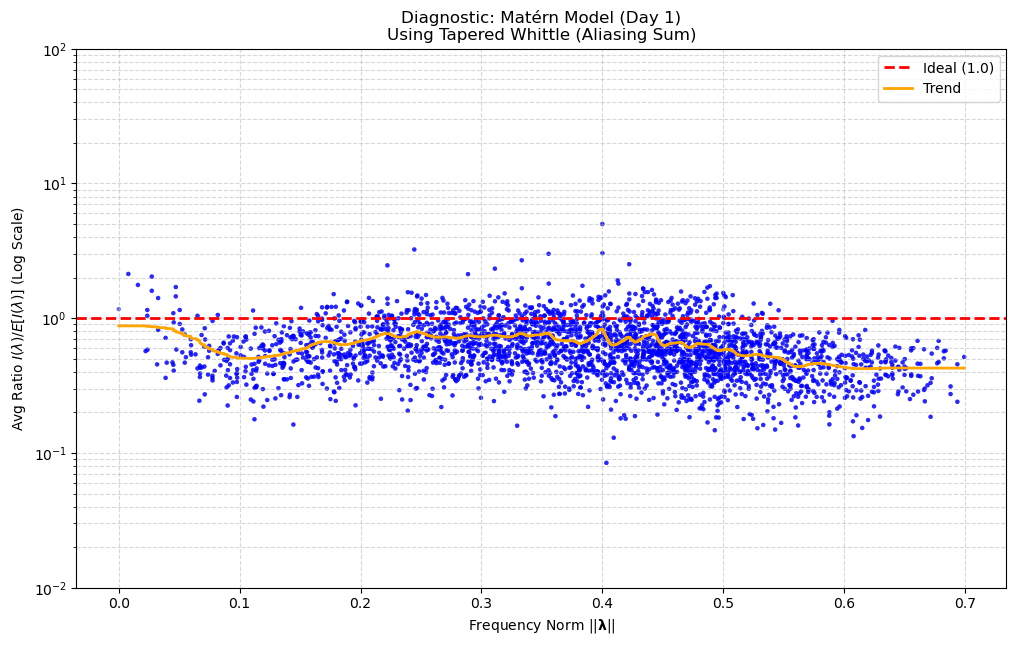

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
import cmath
import sys

# =========================================================================
# 1. The Updated Logic Class (Exactly matching your new requirements)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        """Computes a 2D Hamming window."""
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        hamming1 = 0.54 + 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 + 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        """Computes the normalized taper autocorrelation function c_gn(u) using FFT."""
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        c_gn_grid = autocorr_shifted / (H + 1e-12)
        return c_gn_grid 

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        """Generates J-vector and returns necessary metadata."""
        p_time = len(tensor_list)
        if p_time == 0: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Filter valid tensors
        valid_tensors = [t for t in tensor_list if t.numel() > 0 and t.shape[1] > max(lat_col, lon_col, val_col)]
        if not valid_tensors: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Get Coordinates
        all_lats_cpu = torch.cat([t[:, lat_col] for t in valid_tensors]).cpu()
        all_lons_cpu = torch.cat([t[:, lon_col] for t in valid_tensors]).cpu()
        
        # Simple Nan Filter
        mask = ~torch.isnan(all_lats_cpu) & ~torch.isinf(all_lats_cpu) & ~torch.isnan(all_lons_cpu) & ~torch.isinf(all_lons_cpu)
        all_lats_cpu = all_lats_cpu[mask]
        all_lons_cpu = all_lons_cpu[mask]

        unique_lats_cpu, unique_lons_cpu = torch.unique(all_lats_cpu), torch.unique(all_lons_cpu)
        n1, n2 = len(unique_lats_cpu), len(unique_lons_cpu)

        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats_cpu)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons_cpu)}

        # Generate Taper
        u1_mesh_cpu, u2_mesh_cpu = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64),
            torch.arange(n2, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh_cpu, u2_mesh_cpu), n1, n2).to(device)

        # Fill Data Grid
        fft_results = []
        for tensor in tensor_list:
            data_grid = torch.zeros((n1, n2), dtype=torch.float64, device=device)
            tensor_dev = tensor.to(device) # Move data to device
            
            # Note: Vectorized filling is faster, but keeping your loop for safety/robustness
            for row in tensor:
                lat_val, lon_val, val = row[lat_col].item(), row[lon_col].item(), row[val_col].item()
                if not (np.isnan(lat_val) or np.isnan(lon_val) or np.isnan(val)):
                    i = lat_map.get(lat_val)
                    j = lon_map.get(lon_val)
                    if i is not None and j is not None:
                        data_grid[i, j] = val

            data_grid_tapered = data_grid * taper_grid 
            data_grid_tapered = torch.nan_to_num(data_grid_tapered, nan=0.0)
            fft_results.append(torch.fft.fft2(data_grid_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)

        # Norm Factor
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)

        return J_vector_tensor * norm_factor, n1, n2, p_time, taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        """Calculates sample periodogram I_n = J J^H."""
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        """7-Parameter Spatio-Temporal Kernel (Exponential/Matern 0.5)."""
        device = params.device
        
        # Ensure inputs are tensors
        u1 = torch.as_tensor(u1, device=device, dtype=torch.float64)
        u2 = torch.as_tensor(u2, device=device, dtype=torch.float64)
        t  = torch.as_tensor(t, device=device, dtype=torch.float64)

        # Unpack Parameters
        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        epsilon = 1e-12
        sigmasq = phi1 / (phi2 + epsilon)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + epsilon) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + epsilon) * phi2 

        # Advection
        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t

        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + epsilon)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cov_spatial_difference(u1, u2, t, params, delta1, delta2):
        weights = {(0, 0): -2.0, (1, 0): 1.0, (0, 1): 1.0}
        device = params.device
        cov = torch.zeros_like(u1, device=device, dtype=torch.float64)

        for (a, b), w_ab in weights.items():
            for (c, d), w_cd in weights.items():
                lag_u1 = u1 + (a - c) * delta1
                lag_u2 = u2 + (b - d) * delta2
                cov += w_ab * w_cd * debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(lag_u1, lag_u2, t, params)
        return cov

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        # Convert Grid indices to Physical Lags
        lag_u1 = u1 * delta1
        lag_u2 = u2 * delta2
        
        cov_val = debiased_whittle_likelihood.cov_spatial_difference(lag_u1, lag_u2, t, params, delta1, delta2)

        # Get Taper Autocorrelation from Grid
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]

        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        """Calculates expected periodogram using Aliasing Sum (Lemma 2)."""
        device = params.device
        
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64, device=device),
            torch.arange(n2, dtype=torch.float64, device=device),
            indexing='ij'
        )
        t_lags = torch.arange(p_time, dtype=torch.float64, device=device)
        
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                
                # The 4 Aliasing Terms
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        # FFT and Normalize
        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        norm_factor = 1.0 / (4.0 * cmath.pi**2)
        return fft_result * norm_factor

# =========================================================================
# 3. Main Execution Logic for Plotting
# =========================================================================
if __name__ == '__main__':
    # --- Configuration ---
    DAY_TO_RUN = 1
    # Note: Use the Hamming taper from your new class
    TAPERING_FUNC = debiased_whittle_likelihood.cgn_hamming 
    
    # 💥 CRITICAL: Define Deltas corresponding to your grid resolution
    DELTA_LAT = 0.044 
    DELTA_LON = 0.063
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on: {DEVICE}")

    print(f"--- Day {DAY_TO_RUN} Diagnostic Plot (New Multivariate Tapered Logic) ---")
    
    # --- Define Parameters (Must be the 7 physical params) ---
    # Example: [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    # We must convert these to the LOG parameters required by the kernel
    
    # Physical Values
    sigma_sq_val = 13.07
    range_lat_val = 0.14
    range_lon_val = 0.18
    range_time_val = 1.87
    advec_lat_val = 0.0218
    advec_lon_val = -0.16
    nugget_val = 0.

    # Reparameterization to match kernel expectations:
    # Kernel expects: [log(phi1), log(phi2), log(phi3), log(phi4), advec_lat, advec_lon, log(nugget)]
    phi2 = 1.0 / range_lon_val
    phi1 = sigma_sq_val * phi2
    phi3 = (range_lon_val / range_lat_val)**2
    phi4 = (range_lon_val / range_time_val)**2
    
    best_params_raw = torch.tensor([
        np.log(phi1), 
        np.log(phi2), 
        np.log(phi3), 
        np.log(phi4), 
        advec_lat_val, 
        advec_lon_val, 
        np.log(nugget_val)
    ], device=DEVICE, dtype=torch.float64)

    print(f"Params (Log-Space) on device: {best_params_raw}")

    # --- Data Preparation ---
    # ⚠️ ASSUMING 'subsetted_aggregated_day' IS LOADED IN YOUR ENVIRONMENT
    # If testing standalone, replace this with mock data loading
    try:
        cur_df = subsetted_aggregated_day[DAY_TO_RUN - 1] # Ensure 0-indexed
        cur_df =  subsetted_aggregated_day
        unique_times = torch.unique(cur_df[:, 3])
        tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]
    except NameError:
        print("Error: 'subsetted_aggregated_day' not found. Please load data first.")
        sys.exit(1)

    # --- Step 1: Generate J-Vector & Taper Grid ---
    print("Generating J-Vector and Taper Grid...")
    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, TAPERING_FUNC, lat_col=0, lon_col=1, val_col=2, device=DEVICE
    )
    print(f"Grid: {n1}x{n2}, Time Points: {p_time}")

    # --- Step 2: Sample Periodogram ---
    print("Calculating Sample Periodogram...")
    # J_vec is (n1, n2, p) -> I_sample is (n1, n2, p, p)
    I_sample = debiased_whittle_likelihood.calculate_sample_periodogram_vectorized(J_vec)
    
    # --- Step 3: Taper Autocorrelation (Critical for New Expectation) ---
    print("Calculating Taper Autocorrelation...")
    taper_autocorr_grid = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(
        taper_grid, n1, n2, DEVICE
    )

    # --- Step 4: Expected Periodogram ---
    print("Calculating Expected Periodogram (Using Aliasing Sum)...")
    # Returns (n1, n2, p, p) real tensor
    with torch.no_grad():
        I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
            best_params_raw, n1, n2, p_time, taper_autocorr_grid, DELTA_LAT, DELTA_LON
        )

    # --- Step 5: Plotting Prep (Shift & Diagonal) ---
    # Shift dimensions 0 and 1 (spatial dims). Dims 2 and 3 are time (p x p).
    I_sample_shifted = torch.fft.fftshift(I_sample, dim=(0, 1))
    I_expected_shifted = torch.fft.fftshift(I_expected, dim=(0, 1))

    # We take the diagonal of the p x p time matrix (auto-spectra at each spatial freq)
    # Result is (n1, n2, p)
    diag_sample = torch.diagonal(I_sample_shifted, dim1=-2, dim2=-1).real
    diag_expected = torch.diagonal(I_expected_shifted, dim1=-2, dim2=-1) # Already real

    epsilon = 1e-15
    ratio_grid = diag_sample / (diag_expected + epsilon)
    
    # Average over time steps (optional, or plot specific time step)
    ratio_magnitude_avg = torch.mean(ratio_grid, dim=-1).cpu().numpy()

    # --- Step 6: Visualization ---
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lon_shifted, freq_lat_shifted = fftshift(freq_lon), fftshift(freq_lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
    frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
    
    norm_flat = frequency_norm.flatten()
    ratio_flat = ratio_magnitude_avg.flatten()

    plt.figure(figsize=(12, 7))
    plt.scatter(norm_flat, ratio_flat, s=10, alpha=0.6, c='blue', edgecolors='none')
    plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal (1.0)')
    
    # Add smoothing trend line (optional)
    try:
        from scipy.ndimage import gaussian_filter1d
        sorted_indices = np.argsort(norm_flat)
        plt.plot(norm_flat[sorted_indices], 
                 gaussian_filter1d(ratio_flat[sorted_indices], sigma=50), 
                 color='orange', linewidth=2, label='Trend')
    except ImportError:
        pass

    plt.yscale('log')
    plt.ylim(1e-2, 1e2)
    plt.title(f'Diagnostic: Matérn Model (Day {DAY_TO_RUN})\nUsing Tapered Whittle (Aliasing Sum)')
    plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
    plt.ylabel(r'Avg Ratio $I(\lambda) / E[I(\lambda)]$ (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    print(f"\nStats: Mean={np.mean(ratio_flat):.2f}, Median={np.median(ratio_flat):.2f}")
    plt.show()

univariate

--- Day 1 Diagnostic Plot for Matérn (nu=0.5) ---
Using parameters: [13.06, 0.154, 0.195, 1.0, 0.0218, -0.1689, 0.247]
Data grid: 45x126 spatial points, 8 time points.

Stats: Mean=0.55


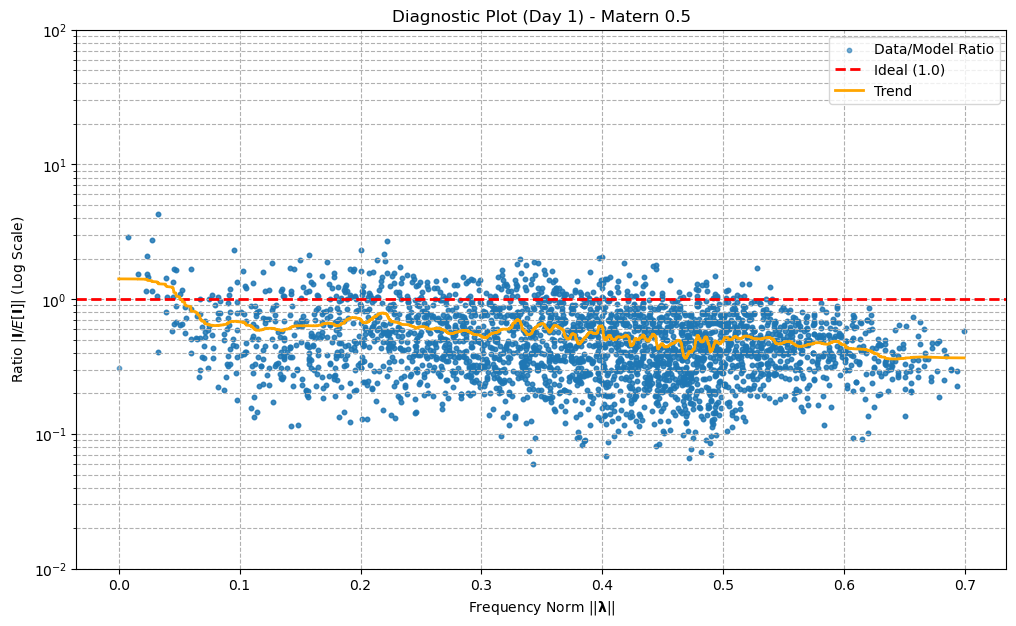

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
import cmath
import sys

# =========================================================================
# 1. Tapering and Modeling Functions
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function (triangular window)."""
    u1, u2 = u
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2) 

def cov_x(u1, u2, t, params, nu=0.5):
    """
    Covariance function for PLOTTING using the Matérn model (nu=0.5 / Exponential).
    It expects parameters in their PHYSICAL (Natural) space.
    """
    # Unpack the 7 parameters (Order must match your optimization output)
    # [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    sigmasq   = params[0]
    range_lat = params[1]
    range_lon = params[2]
    range_time= params[3]
    advec_lat = params[4]
    advec_lon = params[5]
    nugget    = params[6]
    
    # Advection Logic
    u1_adv = u1 - advec_lat * t
    u2_adv = u2 - advec_lon * t
    
    # Distance Calculation (Standardized by ranges)
    # Note: range_time is used here. If you use beta, replace (t/range_time) with (t*beta)
    distance_sq = (u1_adv / range_lat)**2 + (u2_adv / range_lon)**2 + (t / range_time)**2
    distance = torch.sqrt(distance_sq + 1e-12)
    
    # --- 💥 CHANGE: Exponential Kernel (Nu=0.5) ---
    # Formula: sigma^2 * exp(-d)
    matern_cov = sigmasq * torch.exp(-distance)
    
    # Add Nugget at lag 0
    # Note: If distance is ~0, covariance is sigma^2 + nugget
    return torch.where(distance_sq > 1e-9, matern_cov, sigmasq + nugget)

def cov_first_difference(u1, u2, t, params, nu):
    """Computes the autocovariance of the first-difference-filtered process."""
    
    # 💥 CRITICAL: Use your specific grid resolution
    delta1, delta2 = 0.044, 0.063
    
    # Weights for spatial first difference
    stencil_weights = {(0, 0): -2, (1, 0): 1, (0, 1): 1}
    
    cov = torch.zeros_like(u1, dtype=torch.float32)
    
    for (a, b), w_ab in stencil_weights.items():
        for (c, d), w_cd in stencil_weights.items():
            # Apply resolution scaling to lags
            offset_x = (a - c) * delta1
            offset_y = (b - d) * delta2
            
            lag_x = u1 + offset_x
            lag_y = u2 + offset_y
            
            cov += w_ab * w_cd * cov_x(lag_x, lag_y, t, params, nu)
    return cov

def cn_bar(u1, u2, t, params, n1, n2, taper_func, nu):
    """Computes the tapered covariance for the filtered field."""
    u = (u1, u2)
    # Note: u1, u2 here are PHYSICAL lags (already scaled by delta in expected_periodogram)
    # OR they are indices. In this script, 'expected_periodogram' passes INDICES.
    # So 'cov_first_difference' must handle the scaling. 
    # Current setup: cov_first_difference applies deltas to the OFFSETS, 
    # but assumes u1, u2 are already physical.
    # Let's fix this in the main loop below.
    return cov_first_difference(u1, u2, t, params, nu) * taper_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p, taper_func, nu, delta1=0.044, delta2=0.063):
    """Calculates the expected periodogram for the FILTERED field."""
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    
    # Create Index Mesh
    u1_idx, u2_idx = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')

    # Convert Indices to Physical Distances for the covariance function
    u1_phys = u1_idx * delta1
    u2_phys = u2_idx * delta2

    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            # Pass Physical Lags to covariance, but Grid Indices to Taper
            cov_val = cov_first_difference(u1_phys, u2_phys, t, params, nu)
            taper_val = taper_func((u1_idx, u2_idx), n1, n2)
            
            product_tensor[:, :, q, r] = cov_val * taper_val

    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor

# =========================================================================
# 2. Data Processing Functions
# =========================================================================
def generate_Jvector_final(tensor_list, taper_func, lat_col=0, lon_col=1, val_col=2):
    p = len(tensor_list)
    if p == 0:
        return torch.empty(0, 0, 0), 0, 0, 0

    all_lats = torch.cat([t[:, lat_col] for t in tensor_list])
    all_lons = torch.cat([t[:, lon_col] for t in tensor_list])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)

    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}

    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    taper_grid = taper_func((u1_mesh, u2_mesh), n1, n2)

    fft_results = []
    for tensor in tensor_list:
        data_grid = torch.zeros((n1, n2), dtype=torch.float32)
        for row in tensor:
             i = lat_map[row[lat_col].item()]
             j = lon_map[row[lon_col].item()]
             data_grid[i, j] = row[val_col]
        
        data_grid_tapered = data_grid * taper_grid
        fft_results.append(torch.fft.fft2(data_grid_tapered))

    J_vector_tensor = torch.stack(fft_results, dim=2)

    H = torch.sum(taper_grid**2)
    norm_factor = torch.sqrt(1 / H) / (2 * cmath.pi)
    
    return J_vector_tensor * norm_factor, n1, n2, p

def calculate_sample_periodogram_vectorized(J_vector_tensor):
    """Efficient vectorized version."""
    J_col = J_vector_tensor.unsqueeze(-1)
    J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
    return J_col @ J_row_conj

# =========================================================================
# 3. Main Execution Logic
# =========================================================================
if __name__ == '__main__':
    # --- Configuration ---
    DAY_TO_RUN = 1
    TAMPERING_FUNC = cgn_2dbartlett # Or switch to cgn_hamming
    NU_SMOOTHNESS = 0.5 
    
    print(f"--- Day {DAY_TO_RUN} Diagnostic Plot for Matérn (nu={NU_SMOOTHNESS}) ---")
    
    # --- Params (Physical Space) ---
    # [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    # Update these with your fit_vecchia_lbfgs output
    best_params = [13.06, 0.154, 0.195, 1.0, 0.0218, -0.1689, 0.247] 
    
    print(f"Using parameters: {best_params}")
    
    # --- Data Loading (Placeholder: Ensure subsetted_aggregated_day is available) ---
    try:
        cur_df = subsetted_aggregated_day[DAY_TO_RUN - 1]
        cur_df = subsetted_aggregated_day
        unique_times = torch.unique(cur_df[:, 3])
        tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]
    except NameError:
        print("Error: 'subsetted_aggregated_day' variable not found. Please load your data.")
        sys.exit(1)
    
    # --- Calculation ---
    J_vec, n1, n2, p = generate_Jvector_final(tensor_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=2)
    print(f"Data grid: {n1}x{n2} spatial points, {p} time points.")
    
    I_sample = calculate_sample_periodogram_vectorized(J_vec)
    
    # Pass Deltas Explicitly here
    I_expected = expected_periodogram_fft_multivariate(
        best_params, n1, n2, p, TAMPERING_FUNC, 
        nu=NU_SMOOTHNESS, delta1=0.044, delta2=0.063
    )

    # Shift for plotting
    I_sample_shifted = torch.fft.fftshift(I_sample, dim=(-4, -3))
    I_expected_shifted = torch.fft.fftshift(I_expected, dim=(-4, -3))
    
    # Diagonal ratio
    epsilon = 1e-15
    ratio_complex = I_sample_shifted / (I_expected_shifted + epsilon)
    diagonal_ratio = torch.diagonal(ratio_complex, dim1=-2, dim2=-1) 
    ratio_magnitude_avg = torch.mean(torch.abs(diagonal_ratio), dim=-1)
    
    # --- Plotting ---
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lon_shifted, freq_lat_shifted = fftshift(freq_lon), fftshift(freq_lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
    frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
    
    norm_flat = frequency_norm.flatten()
    ratio_flat = ratio_magnitude_avg.detach().numpy().flatten()

    plt.figure(figsize=(12, 7))
    plt.scatter(norm_flat, ratio_flat, s=10, alpha=0.6, label='Data/Model Ratio')
    plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal (1.0)')
    
    # Add trend line
    from scipy.ndimage import gaussian_filter1d
    sorted_idx = np.argsort(norm_flat)
    plt.plot(norm_flat[sorted_idx], gaussian_filter1d(ratio_flat[sorted_idx], sigma=30), 
             color='orange', linewidth=2, label='Trend')

    plt.yscale('log')
    plt.ylim(1e-2, 1e2)
    plt.title(f'Diagnostic Plot (Day {DAY_TO_RUN}) - Matern 0.5')
    plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
    plt.ylabel(r'Ratio $|\mathbf{I} / E[\mathbf{I}]|$ (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    print(f"\nStats: Mean={np.mean(ratio_flat):.2f}")
    plt.show()